In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import smplotlib
from numpy.random import *
import secrets
from scipy.optimize import curve_fit

In [2]:
seed = secrets.randbits(128)
rng_default = np.random.default_rng(seed)

### 1) Write a program that generates random realizations of the Cauchydistribution with null location and unit scale:
### \begin{equation}
     f(x) = \frac{1}{\pi (1 + x^2)}
 \end{equation}

\begin{equation}
    F(x) = \int_{-\infty}^x f(x')dx'=\frac{1}{\pi}\int_{-\infty}^x \frac{dx'}{1+x'^2}=\frac{1}{\pi} \arctan{x'}|_{-\infty}^x =
    \frac{1}{\pi} \left[ \arctan{x} + \frac{\pi}{2} \right] = \frac{1}{\pi} \arctan{x} + \frac{1}{2}
\end{equation}

In [3]:
def f(x):
    return 1.0/(np.pi*(1.0 + np.square(x)))

def F(x):
    return 1.0/np.pi * np.arctan(x)+0.5

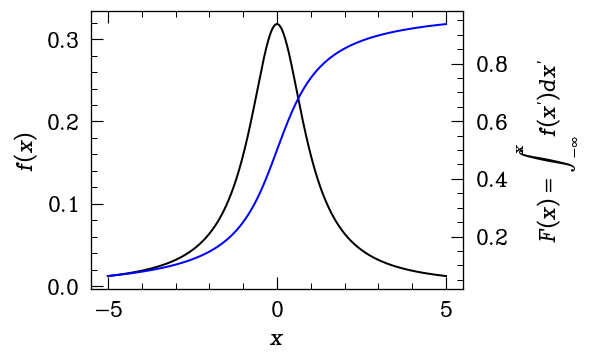

In [4]:
x = np.linspace(-5.0, 5.0, 1000)

fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.plot(x, f(x))

ax2 = ax.twinx()
ax2.set_ylabel(r"$F(x)=\int_{-\infty}^x f(x')dx'$")
ax2.plot(x, F(x), c='b')

\begin{equation}
    y = F(x) = \frac{1}{\pi} \arctan{x} + \frac{1}{2} \rightarrow \pi \left( y-\frac{1}{2} \right) = \arctan{x}.
\end{equation}
Then,
\begin{equation}
    x = F^{-1}(y) = \tan \left[ \pi \left( y-\frac{1}{2} \right) \right].
\end{equation}

In [5]:
def Finv(y):
    return np.tan(np.pi*(y-0.5))

def RandomCauchy(N, rng=rng_default):
    y = rng.random(N)
    return Finv(y)

### 2) Make a histogram between -5 and 5 with 50 bins, for a random realization with 1,000 points, together with the theoretical curve. Make sure that the histogram and theoretical curve have the same units.

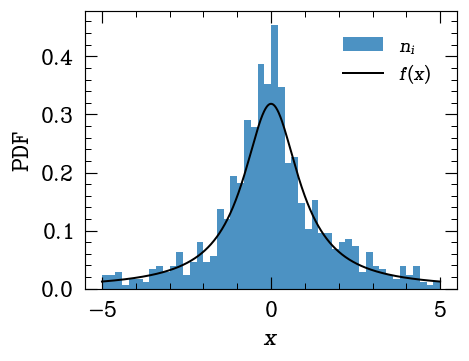

In [6]:
N = 1000
nbins = 50

xi = RandomCauchy(N)

fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'PDF')
ax.hist(xi, bins=nbins, range=(-5, 5), color='tab:blue', density=True, label=r'$n_i$', alpha=0.8)
ax.plot(x, f(x), label=r'$f(x)$')
ax.legend(fontsize=12)

### 3) Make a plot of the fractional difference for the plot above.

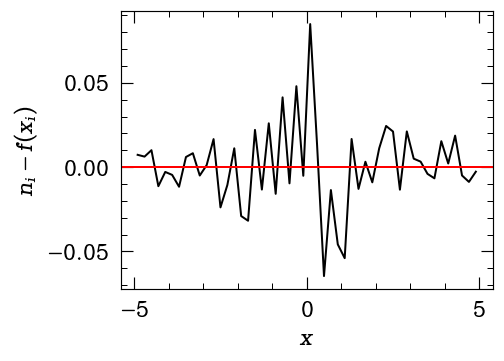

In [7]:
ni, bins = np.histogram(xi, bins=nbins, range=(-5, 5))
bins_centered = 0.5*(bins[:-1] + bins[1:])
FracDiff = ni / (N * np.diff(bins)) - f(bins_centered)

fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$n_i - f(x_i)$')
ax.plot(bins_centered, FracDiff)
ax.axhline(0.0, c='r')

### 4) Try now samples of different sizes and compute the global rms deviations between both curves as a function of the size of the random realization. Try a range in size from at least $100$ points up to at least $10^6$.

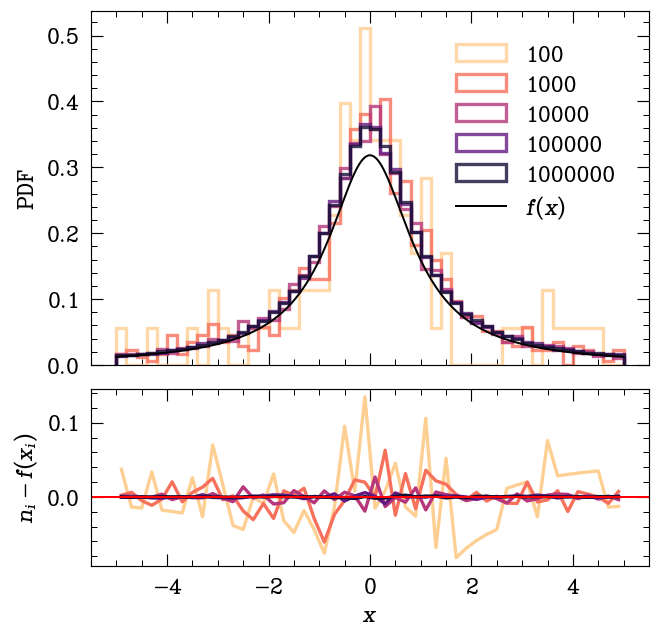

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

N = np.geomspace(100, 1e6, 5, dtype=np.int32)

cmap = mpl.cm.get_cmap('magma_r')
colors = cmap(np.linspace(0.1, 0.9, len(N)))

for i, Ni in enumerate(N):
    xi = RandomCauchy(Ni)
    ni, bins = np.histogram(xi, bins=nbins, range=(-5, 5))
    bins_centered = 0.5*(bins[:-1] + bins[1:])
    FracDiff = ni / (Ni * np.diff(bins)) - f(bins_centered)
    
    ax1.hist(xi, bins=nbins, range=(-5, 5), color=colors[i], density=True, label=str(Ni), alpha=0.8, histtype='step', lw=2)
    ax2.plot(bins_centered, FracDiff, color=colors[i], lw=2)

ax1.plot(x, f(x), label=r'$f(x)$')
ax1.set_ylabel(r'PDF')
ax1.legend()
ax2.set_ylabel(r'$n_i - f(x_i)$')
ax2.axhline(0.0, c='r')
ax2.set_xlabel(r'$x$')

plt.subplots_adjust(hspace=0.09)

\begin{equation}
    {\rm RMS ~ deviation} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (f(x_i) - g(x_i))^2}
\end{equation}

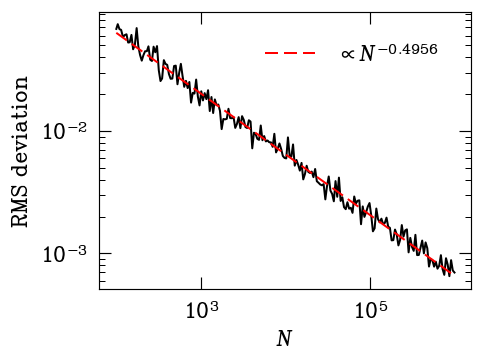

In [11]:
N = np.geomspace(100, 1e6, 200, dtype=np.int32)
RMSdev = np.zeros(len(N))

for i, Ni in enumerate(N):
    xi = RandomCauchy(Ni)
    ni, bins = np.histogram(xi, bins=nbins, range=(-5, 5))
    bins_centered = 0.5*(bins[:-1] + bins[1:])
    FracDiff = ni / (Ni * np.diff(bins)) - f(bins_centered)
    RMSdev[i] = np.sqrt(1.0/nbins * np.sum(np.square(FracDiff)))

def FE_fit(N, A, alpha):
    return A * np.power(N, -alpha)

def logFE_fit(logN, A, alpha):
    return A - alpha * logN

#popt, pcov = curve_fit(FE_fit, N, RMSdev, p0=(1, 0.5))
popt, pcov = curve_fit(logFE_fit, np.log(N), np.log(RMSdev))

fig, ax = plt.subplots(figsize=(4, 3))

ax.set_xlabel(r'$N$')
ax.set_ylabel(r'RMS deviation')
ax.loglog(N, RMSdev)
ax.loglog(N, np.exp(logFE_fit(np.log(N), *popt)), ls='--', c='r', label=r'$\propto N^{' + "{:.4f}".format(-popt[1]) + '}$')

ax.legend()